# Precision-Recall-Tradeoff

The $F_1$ score is a metric suited to compare classification models to each other. However, it might be desirable to have a high precision if you want to trust data passing a filter based on a classification algorithm (e.g. a classification algorithm determines which websites can visit a child). Increasing precision result commonly in a smaller recall. This is know as precision-recall-tradeoff. We can plot this for our example:   

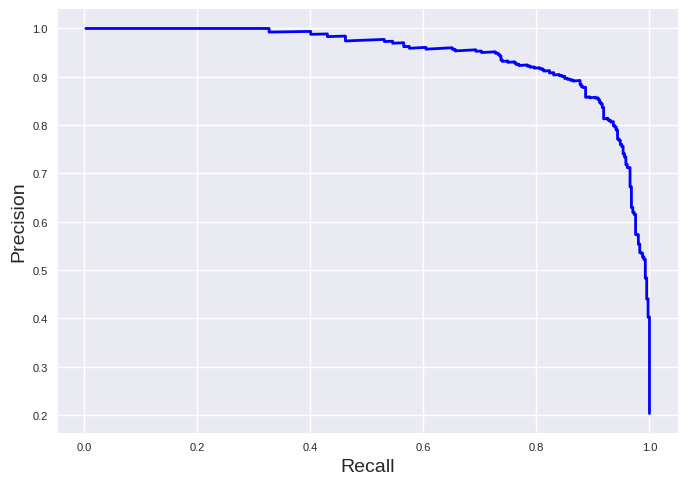

In [1]:
# code of a previous notebook of this section
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector
import numpy as np
from sklearn.svm import SVC

data = pd.read_csv('cl1_data.csv')

train_set, test_set = train_test_split(data, test_size=0.2, random_state=42)

y_train = train_set['label']
X_train = train_set.drop(['label'], axis=1)

num_pipeline = make_pipeline(StandardScaler()) 

preprocessing = ColumnTransformer([("num",num_pipeline, make_column_selector(dtype_include=np.number))])

model_svc = make_pipeline(preprocessing, SVC(kernel='rbf', C=1.0)) 
model_svc.fit(X_train, y_train)
# end of code from a previous notebook of this section

from sklearn.model_selection import cross_val_predict
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

y_scores_svc = cross_val_predict(model_svc, X_train, y_train, cv=5, method="decision_function")

precision_svc, recall_svc, decision_func_svc = precision_recall_curve(y_train, y_scores_svc, pos_label='group2')

plt.style.use('seaborn-v0_8')

plt.plot(recall_svc[:-1], precision_svc[:-1], "b", linewidth=2)
plt.xlabel("Recall", fontsize=14)
plt.ylabel("Precision", fontsize=14)
plt.tick_params(labelsize=8)

plt.show()

It is most desirable to have a curve strongly locates on the top right corner. Thus, you can compare models to each other by this curve or the area below the precision-recall-curve. The area is accessible by: 

In [2]:
from sklearn.metrics import auc

print('Area under the precision-recall-curve: %0.3f' % (auc(recall_svc, precision_svc)))

Area under the precision-recall-curve: 0.945


The area under the precision-recall curve is not available as scoring function in scikit-learn. However, you can use the average precision as scoring function which is given by:

$AP = \sum\limits_i (R_i - R_{i-1})P_i)$

$R_i$ and $P_i$ are recall and precision for a threshold at the ith point. Thus, it is a numerical integration of the precision-recall curve. It produces a value close to the area under the precision-recall curve since the number of data points are large enough to mitigate the effect of wiggles.  

In [3]:
from sklearn.metrics import average_precision_score

average_precision = average_precision_score(y_train, y_scores_svc, pos_label='group2')
print('Average precision: %0.3f' % (average_precision))

Average precision: 0.945


We can also plot precision and recall versus the threshold of the decision function which is in case of a support vector classification the distance to the decision boundary:

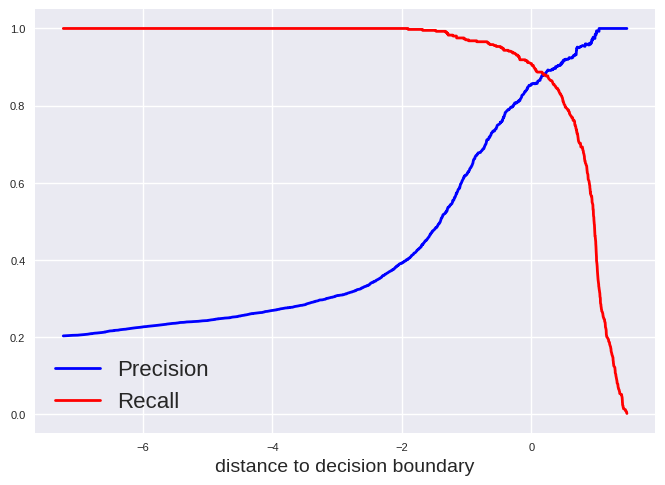

In [4]:
plt.style.use('seaborn-v0_8')

plt.plot(decision_func_svc, precision_svc[:-1], "b", label="Precision", linewidth=2)
plt.plot(decision_func_svc, recall_svc[:-1], "r", label="Recall", linewidth=2)
plt.xlabel("distance to decision boundary", fontsize=14)
plt.tick_params(labelsize=8)
plt.legend(fontsize=16)

plt.show()

We can get the distance to the decision boundray for a data point by following lines:

In [5]:
test_model_svc = pd.DataFrame([[0.6, 0.3],[0.7,0.4]], columns=['feature1', 'feature2'])
y_scores_svc_example = model_svc.decision_function(test_model_svc)
print(y_scores_svc_example)

[ 1.02153563 -0.78361566]


A value of 0 means the data point is exactly located on the decision boundary. A positive value results in "True" while a negative value results in a "False" classification with the default settings for a SVC. Thus, the default settings will always assign an instance as "True" if it is has at least a probability of 50% to be correct.

We can change this of course. For example, let us choose a model which has at least a precision of 0.9 at the cost of recall. We can get the corresponding distance to the decision boundary by: 

In [6]:
idx_for_90_precision_svc = (precision_svc >= 0.90).argmax()
distance_for_90_precision_svc = decision_func_svc[idx_for_90_precision_svc]
print("At a decision boundary distance of %0.3f was reached the first time a precision of 90%%" % (distance_for_90_precision_svc))

At a decision boundary distance of 0.373 was reached the first time a precision of 90%


We can also calculate the metrics for this model and compare it to our model with the default settings:

In [7]:
from sklearn.metrics import precision_score,recall_score, f1_score

y_train_svc_pred = cross_val_predict(model_svc, X_train, y_train, cv=5)

print('Precision (default value): %0.3f' % (precision_score(y_train, y_train_svc_pred,pos_label='group2')))
print('Recall (default value): %0.3f'% (recall_score(y_train, y_train_svc_pred, pos_label='group2')))
print('F1-score (default value): %0.3f'% (f1_score(y_train, y_train_svc_pred, pos_label='group2')))

y_pred_svc_0373 = np.where(y_scores_svc >= 0.373, 'group2', 'group1')
print('\nPrecision (decision boundary at 0.373): %0.3f' % (precision_score(y_train, y_pred_svc_0373, pos_label='group2')))
print('Recall (decision boundary at 0.373): %0.3f'% (recall_score(y_train, y_pred_svc_0373, pos_label='group2')))
print('F1-score (decision boundary at 0.373): %0.3f'% (f1_score(y_train, y_pred_svc_0373, pos_label='group2')))

Precision (default value): 0.856
Recall (default value): 0.909
F1-score (default value): 0.882

Precision (decision boundary at 0.373): 0.901
Recall (decision boundary at 0.373): 0.848
F1-score (decision boundary at 0.373): 0.873


Some classifier do not have a decision function which provides access to a class probability. One example is random forests. However, you can use "predict_proba" to generate class probabilities for these models:  

In [8]:
from sklearn.ensemble import RandomForestClassifier

model_rf = RandomForestClassifier(random_state=42)

y_probas_rf = cross_val_predict(model_rf, X_train, y_train, cv=5, method="predict_proba")
y_probas_rf[:5]

array([[0.04, 0.96],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [0.67, 0.33],
       [0.96, 0.04]])

In case of random forests, the predicted probability is obtained by the number of decision trees in the forest, which predict this class as "True", divided by the total number of decision trees in the forest. The calculated probability can be used similar as the decision function, for example to plot the precision-recall-curve which allows to compare classification models:

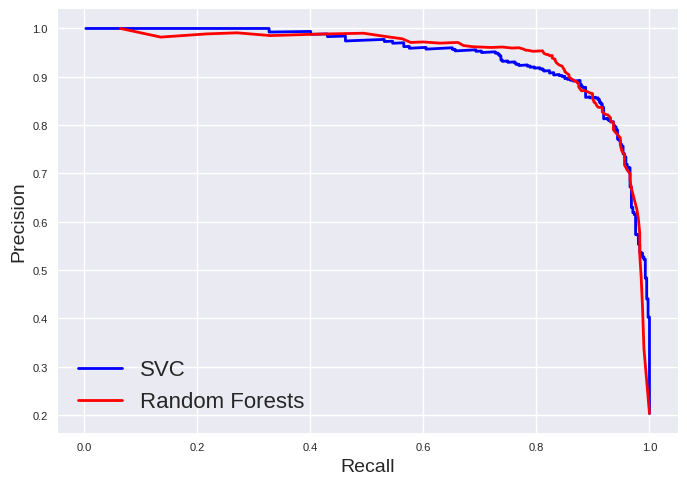

In [9]:
# We select the second column which is the "True" label.
y_scores_rf = y_probas_rf[:, 1]
precision_rf, recall_rf, threshold_rf = precision_recall_curve(y_train, y_scores_rf, pos_label='group2')

plt.plot(recall_svc[:-1], precision_svc[:-1], "b", label="SVC", linewidth=2)
plt.plot(recall_rf[:-1], precision_rf[:-1], "r", label="Random Forests", linewidth=2)
plt.xlabel("Recall", fontsize=14)
plt.ylabel("Precision", fontsize=14)
plt.tick_params(labelsize=8)
plt.legend(fontsize=16)

plt.show()